In [3]:
import dlop_ldn_function_bases as bases
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import tqdm

In [10]:
def mk_mod_fourier_lti(q, fac=0.9, Ninternal=1000):
    def mk_fourier_oscillator(q, mul=1.0):
        B = (np.arange(0, q) + 1) % 2
        A = np.zeros((q, q))
        for k in range(1, q):
            ki = (k + 1) // 2
            fk = 2.0 * np.pi * mul * ki
            A[2 * ki - 1, 2 * ki - 1] = 0
            A[2 * ki - 1, 2 * ki + 0] =  fk
            A[2 * ki + 0, 2 * ki - 1] = -fk
            A[2 * ki + 0, 2 * ki + 0] = 0
        return A, B

    assert q % 2 == 1

    A, B = mk_fourier_oscillator(q, mul=0.9)
    Ad, Bd = np.zeros((q, q)), np.zeros((q,))

    Ad[1:, 1:], Bd[1:] = bases.discretize_lti(1.0 / Ninternal, A[1:, 1:], B[1:])
    Bd[0] = 1e-3
    Ad[0, 0] = 1.0

    H = bases.mk_lti_basis(Ad, Bd, Ninternal, from_discrete_lti=True, normalize=False)
    enc = H[:, 0]
    dec = np.linalg.pinv(H, rcond=1e-2)[0]

    Ad = Ad - np.outer(enc, dec) @ Ad
    Bd = Bd - np.outer(enc, dec) @ Bd

    A = np.real(scipy.linalg.logm(Ad)) * Ninternal
    return A, B

In [11]:
def mk_mod_fourier_basis(q, N, Nmul=1, fac=0.9, Ninternal=1000):
    A, B = mk_mod_fourier_lti(q, fac, Ninternal)
    return bases.mk_lti_basis(A, B, N, N * Nmul)

In [16]:
def mexpfin(A, o):
    if o == 0:
        return np.eye(A.shape[0])
    res = np.zeros_like(A)
    f = 1.0
    for i in range(1, o + 1):
        res += np.linalg.matrix_power(A, i) * f
        f /= (i + 1)
    return res

qs = np.arange(1, 100, 2, dtype=int)
Ns = np.arange(1, 1000, 10, dtype=int)
stbl = np.zeros((len(qs), len(Ns)))
for i, q in tqdm.tqdm(enumerate(qs)):
    Ap, _ = mk_mod_fourier_lti(q)
    #Ap, _ = bases.mk_ldn_lti(q)
    for j, N in enumerate(Ns):
        # Euler
        A = Ap / N

        # Midpoint
        A = mexpfin(A, 2)

        # Runge-Kutta
        #A = mexpfin(A, 4)

        # ZOH
        #A = scipy.linalg.expm(A) - np.eye(q)

        for _ in range(10):
            Λ = np.linalg.eigvals(A + 0.01 / N * np.random.randn(q, q))
            #sel = np.real(Λ) < 0.0
            #if len(sel) > 0:
            stbl[i, j] += 0.1 * np.max(np.abs(1 + Λ))

50it [01:32,  1.86s/it]


In [36]:
def mexpfin(A, o):
    if o == 0:
        return np.eye(A.shape[0])
    res = np.zeros_like(A)
    f = 1.0
    for i in range(1, o + 1):
        res += np.linalg.matrix_power(A, i) * f
        f /= (i + 1)
    return res

qs = np.arange(1, 50, 4, dtype=int)
Ns = np.arange(5, 1000, 10, dtype=int)
stbl = np.zeros((len(qs), len(Ns)))
for i, q in tqdm.tqdm(enumerate(qs)):
    Ap, Bp = mk_mod_fourier_lti(q)
    #Ap, _ = bases.mk_ldn_lti(q)
    for j, N in enumerate(Ns):
        # Euler
        A = Ap / N

        # Midpoint
        A = mexpfin(A, 2)

        # Runge-Kutta
        #A = mexpfin(A, 4)

        # ZOH
        #A = scipy.linalg.expm(A) - np.eye(q)

        # Compute the basis transformation matrix
        At, Bt = A + np.eye(q), Bp / N
        H = np.zeros((q, N))
        Aexp = np.eye(q)
        for k in range(N):
            H[:, N - k - 1] = Aexp @ Bt
            Aexp = At @ Aexp
        H = H / np.linalg.norm(H, axis=1)[:, None]
        #print(H)
        #fig, ax = plt.subplots()
        #ax.plot(H.T)

        # Compute the singular value sum
        _, S, _ = np.linalg.svd(H)
        sigma = np.sum(S / np.max(S))

        H_ref = bases.mk_lti_basis(Ap, Bp, N)
        _, S_ref, _ = np.linalg.svd(H_ref)
        sigma_ref = np.sum(S_ref / np.max(S_ref))

        stbl[i, j] = sigma / sigma_ref
        
        #for _ in range(10):
        #    Λ = np.linalg.eigvals(A + 0.01 / N * np.random.randn(q, q))
        #    #sel = np.real(Λ) < 0.0
        #    #if len(sel) > 0:
        #    stbl[i, j] += 0.1 * np.max(np.abs(1 + Λ))

13it [01:53,  8.71s/it]


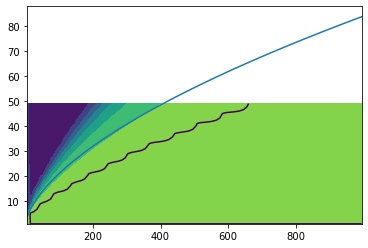

In [37]:
fig, ax = plt.subplots()
ax.contourf(Ns, qs, stbl)
ax.contour(Ns, qs, stbl, levels=[1.0])
ax.plot(Ns, 1.33 * np.power(Ns, 0.6))

In [38]:
stbl

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.36603842, 1.0514438 , 1.04144451, ..., 1.00083859, 1.00083004,
        1.00082165],
       [0.2400045 , 0.25275237, 0.83998472, ..., 1.00069821, 1.00069102,
        1.00068398],
       ...,
       [0.21802913, 0.08551628, 0.06332914, ..., 1.00083965, 1.00082892,
        1.00081844],
       [0.24864073, 0.07821852, 0.0577273 , ..., 1.00088217, 1.00087077,
        1.00085963],
       [0.21287181, 0.07524848, 0.05242807, ..., 1.0009344 , 1.00092237,
        1.0009106 ]])

In [34]:
stbl

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [388]:
A = np.ones((1, 1))
np.linalg.eigvals(A)

array([1.])

In [391]:
A = bases.mk_ldn_lti(20)[0]
np.linalg.eigvals(scipy.linalg.expm(A))

array([-7.76053021e-04+1.23480840e-04j, -7.76053021e-04-1.23480840e-04j,
        1.72792504e-06+3.83924388e-06j,  1.72792504e-06-3.83924388e-06j,
        3.93961354e-08+9.46669008e-08j,  3.93961354e-08-9.46669008e-08j,
       -4.97712397e-09+3.27594068e-09j, -4.97712397e-09-3.27594068e-09j,
        1.07505074e-09+0.00000000e+00j, -9.38597557e-10+0.00000000e+00j,
        5.09511830e-10+1.51086821e-11j,  5.09511830e-10-1.51086821e-11j,
        3.28108835e-11+3.60681465e-10j,  3.28108835e-11-3.60681465e-10j,
       -9.99304577e-11+0.00000000e+00j, -5.19626347e-11+0.00000000e+00j,
        3.79006962e-11+0.00000000e+00j, -1.55567270e-11+0.00000000e+00j,
        4.33014870e-12+5.25976434e-12j,  4.33014870e-12-5.25976434e-12j])

In [128]:
A = bases.mk_ldn_lti(20)[0] / 26
np.abs(np.linalg.eigvals(scipy.linalg.expm(A) - np.eye(20)))

array([1.10561761, 1.10561761, 0.94577718, 0.94577718, 0.84787641,
       0.84787641, 0.78049505, 0.78049505, 0.73188686, 0.73188686,
       0.69626287, 0.69626287, 0.67037268, 0.67037268, 0.65226758,
       0.65226758, 0.64076125, 0.64076125, 0.63516607, 0.63516607])

In [350]:
q, N, mode = 6, 20, "zoh"

In [351]:
# (Approximately) determine asymptotic stability
A, B = bases.mk_ldn_lti(q)
A, B = A / N, B / N  # Apply the timestep
if mode == "zoh":
    Ad = scipy.linalg.expm(A)
    Bd = np.linalg.solve(A, (Ad - np.eye(A.shape[0])) @ B)
    A, B = Ad - np.eye(q), Bd
elif mode == "euler":
    pass
elif mode == "midpoint":
    A = mexpfin(A, 2)
elif mode == "runge_kutta":
    A = mexpfin(A, 4)

In [352]:
At, Bt = A + np.eye(q), B
H = np.zeros((q, N))
Aexp = np.eye(q)
for i in range(N):
    H[:, N - i - 1] = Aexp @ Bt
    Aexp = At @ Aexp
H = H / np.linalg.norm(H, axis=1)[:, None]

In [353]:
H_ref = bases.mk_ldn_basis(q, N, normalize=True)

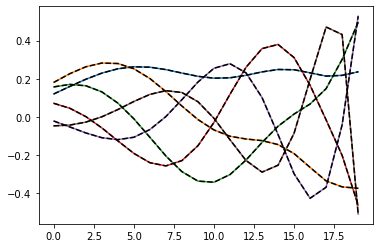

In [354]:
fig, ax = plt.subplots()
ax.plot(H[:6].T);
ax.plot(H_ref[:6].T, 'k--');